In [1]:
%%capture
!git clone https://github.com/renansantosmendes/ai_runtime_core.git

In [2]:
!uv pip install unsloth psutil -qqq

In [3]:
import torch
from unsloth import FastLanguageModel
from datasets import load_dataset
from unsloth.chat_templates import get_chat_template
from trl import SFTTrainer, SFTConfig
from transformers import TrainingArguments


file_path = "/content/ai_runtime_core/genai_and_advanced_analytics/datasets/"
file_name = "synapseai_conversations.jsonl"

dataset = load_dataset(
    path=file_path,
    data_files=file_name,
    split="train"
    )

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-3B-Instruct",
    max_seq_length=2048,
    load_in_4bit=True,
)


model = FastLanguageModel.get_peft_model(
    model,
    r=32,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
)

tokenizer = get_chat_template(
    tokenizer,
    chat_template="llama-3.2",
)

==((====))==  Unsloth 2025.12.10: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Unsloth 2025.12.10 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [5]:
def formatting_func(examples):
    convos = examples["conversations"]
    texts = []
    for convo in convos:
        text = tokenizer.apply_chat_template(
            convo,
            tokenize=False,
            add_generation_prompt=True
        )
        texts.append(text)
    return {"text": texts}

dataset = dataset.map(formatting_func, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [7]:
args = SFTConfig(
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    warmup_ratio=0.1,
    num_train_epochs=30,
    learning_rate=5e-5,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    logging_steps=1,
    output_dir="outputs",
    optim="adamw_8bit",
    seed=42,
    dataset_num_proc=2,
    max_grad_norm=0.3,
    )


trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text",
    max_seq_length=2048,
    args=args,
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

🦥 Unsloth: Padding-free auto-enabled, enabling faster training.


In [8]:
%%time
trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100 | Num Epochs = 30 | Total steps = 390
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 48,627,712 of 3,261,377,536 (1.49% trained)


Step,Training Loss
1,3.878600
2,3.860300
3,3.887900
4,3.901400
5,3.808500
6,3.878200
7,3.766000
8,3.818400
9,3.863100
10,3.796600


Unsloth: Will smartly offload gradients to save VRAM!
CPU times: user 15min 15s, sys: 3.43 s, total: 15min 18s
Wall time: 15min 56s


TrainOutput(global_step=390, training_loss=0.4536214429025467, metrics={'train_runtime': 950.9368, 'train_samples_per_second': 3.155, 'train_steps_per_second': 0.41, 'total_flos': 8326169131991040.0, 'train_loss': 0.4536214429025467, 'epoch': 30.0})

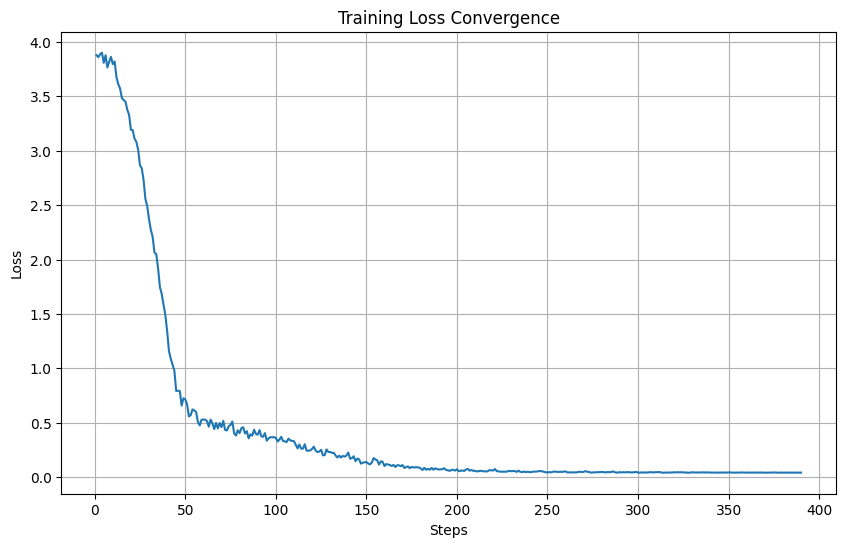

In [9]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
steps = [x["step"] for x in log_history if "loss" in x]
losses = [x["loss"] for x in log_history if "loss" in x]

# Plotar
plt.figure(figsize=(10, 6))
plt.plot(steps, losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Convergence")
plt.grid(True)
plt.savefig("loss_convergence.png")
plt.show()

In [ ]:
from typing import Any
import torch
from pydantic import BaseModel, Field
from unsloth import FastLanguageModel


from typing import Any
import torch
from pydantic import BaseModel, Field


class SynapseAIChatbot(BaseModel):
    """A chatbot interface for SynapseAI Solutions language model."""

    model_config = {"arbitrary_types_allowed": True}

    model: Any
    tokenizer: Any
    max_new_tokens: int = Field(default=256, ge=1, le=4096)
    device: str = "cuda"
    system_prompt: str = (
        "Você é um assistente corporativo da SynapseAI Solutions, "
        "uma empresa especializada em produtos de IA Generativa para Finanças, "
        "Educação e Saúde. Você responde de forma técnica, precisa e profissional, "
        "sempre alinhado às capacidades dos produtos FinBrain, RiskGen, "
        "EduMentor AI, CourseGen Studio e ClinicaGPT. Você respeita LGPD, "
        "compliance regulatório e uso responsável de IA."
    )
    history: list[dict[str, str]] = Field(default_factory=list)

    def model_post_init(self, __context) -> None:
        """Initialize conversation with system prompt after model creation."""
        if not self.history:
            self.history.append({"role": "system", "content": self.system_prompt})

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def chat(self, user_message: str) -> str:
        """Send a message and receive a response from the chatbot.

        Args:
            user_message: The user's input message.

        Returns:
            Only the assistant's generated response.
        """
        self.history.append({"role": "user", "content": user_message})

        inputs = self.tokenizer.apply_chat_template(
            conversation=self.history,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt"
        ).to(self.device)

        attention_mask = torch.ones_like(inputs)
        input_length = inputs.shape[1]

        outputs = self.model.generate(
            input_ids=inputs,
            attention_mask=attention_mask,
            pad_token_id=self.tokenizer.pad_token_id,
            max_new_tokens=self.max_new_tokens
        )

        # Extrair apenas os tokens gerados
        new_tokens = outputs[0][input_length:]
        assistant_response = self.tokenizer.decode(
            new_tokens,
            skip_special_tokens=True
        ).strip()

        self.history.append({"role": "assistant", "content": assistant_response})

        return assistant_response

    def reset(self) -> None:
        """Clear conversation history and reinitialize with system prompt."""
        self.history.clear()
        self.history.append({"role": "system", "content": self.system_prompt})

In [ ]:
FastLanguageModel.for_inference(model)

chatbot = SynapseAIChatbot(
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512
)


response = chatbot.chat("O que é o FinBrain?")
print(response)

response = chatbot.chat("E o RiskGen?")
print(response)

print(chatbot.history)

chatbot.reset()

Um assistente de IA generativa especializado em análise financeira, contabilidade e planejamento estratégico.
Um sistema de IA para gestão de riscos, compliance regulatório e auditoria.
[{'role': 'system', 'content': 'Você é um assistente corporativo da SynapseAI Solutions, uma empresa especializada em produtos de IA Generativa para Finanças, Educação e Saúde. Você responde de forma técnica, precisa e profissional, sempre alinhado às capacidades dos produtos FinBrain, RiskGen, EduMentor AI, CourseGen Studio e ClinicaGPT. Você respeita LGPD, compliance regulatório e uso responsável de IA.'}, {'role': 'user', 'content': 'O que é o FinBrain?'}, {'role': 'assistant', 'content': 'Um assistente de IA generativa especializado em análise financeira, contabilidade e planejamento estratégico.'}, {'role': 'user', 'content': 'E o RiskGen?'}, {'role': 'assistant', 'content': 'Um sistema de IA para gestão de riscos, compliance regulatório e auditoria.'}]


In [10]:
model.push_to_hub("renansantosmendes/synapseai-llama3.2-3B-instruct-lora-v3")
tokenizer.push_to_hub("renansantosmendes/synapseai-llama3.2-3B-instruct-lora-v3")

README.md:   0%|          | 0.00/591 [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   0%|          |  559kB /  195MB            

Saved model to https://huggingface.co/renansantosmendes/synapseai-llama3.2-3B-instruct-lora-v3


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mp_5szoiut/tokenizer.json: 100%|##########| 17.2MB / 17.2MB            

In [ ]:
2